# TARGET PROBABILITY FUNCTION

Il ruolo di questo notebook è definire una funzione che, dati i numeri di azioni possibili (mappiamo ad ogni azione un indice), il "reward" ricevuto (normalizzato tra 1 e -1) e la sequenza di azioni eseguite definisca una funzione di probabilità discreta ad ogni passo. Per far capire come lavora questa funzione di probabilità target usiamo un esempio pratico (con reward 1 per semplificarci le cose):

si supponga di avere solo 3 possibili azioni :  A, B, C; 

immaginiamo che la nostra "action history" sia la seguente : 1->A; 2->B; 3->C (solo 3 passi)

noi siamo sicuri solo delle ultime azioni (che ci hanno portato al reward) mentre del resto siamo insicuri, per questo motivo, linearmente, decresciamo la certezza sull'aver compiuto "l'azione corretta". Allora come procediamo? Procediamo come segue: 

definiamo la funzione di probabilità target così:

| | 3 | 2 | 1 |
|-|-|-|-|
|A|0 |0.175|0.5|
|B|0|0.75|0.25|
|C|1|0.175|0.25|

ossia : 
1. definiamo la probabilità dell'ultima azione come 1. il restante sarà 0.
2. calcoliamo il "passo", ossia di quanto deve decrementare linearmente la probabilità dell' "azione compiuta". Il metodo è immediato: abbiamo una probabilità finale a cui vogliamo puntare (generalmente 0.5 ma si possono pensare altre strategie) e dunque il "passo" sarà (1 - 0.5)/numero_azioni_compiute.
3. ci basta quindi ad ogni passo iterativamente sottrarre la probabilità dell'azione compiuta ed abbiamo finito il nostro lavoro. il resto d'altronde ci è sufficientemente "colmarlo" distribuendo la probabilità restante uniformamente sulle altre azioni. 

il reward si introduce in realtà in maniera più intelligente di quella sovra descritta ed è sufficiente leggere il codice per derivare le formule matematiche usate per esso. le implementazioni a reward positivo ed a reward negativo sono leggermente diverse.

per far capire, nel caso precedente, a reward negativo -1 dovevamo ottenere la seguente funzione target (ci vogliamo allontare il più possibile da ciò che abbiamo compiuto).

| | 3 | 2 | 1 |
|-|-|-|-|
|A|0.5 |0.375|0.5|
|B|0.5|0.25|0.25|
|C|0|0.375|0.25|

il reward è definito in modo tale che, con r = 0 otteniamo la distribuzione uniforme discreta (bisogna fare uno shuffle) mentre tutti i valori maggiori ci fanno ottenere distribuzioni discrete "a favore" delle azioni che abbiamo compiuto. non sempre sono "nettamente" a favore ma rispettano sempre le proprietà di decrescita.

In [1]:
import numpy as np

In [2]:
def target_linear_scaling_distribution(reward, actions_history, number_of_actions, pend = 0.5):
    target = []
    actions_history.reverse()
    history_length = len(actions_history)
    kp = reward*(number_of_actions-1)/number_of_actions
    kq = reward*(1/number_of_actions)
    p0 = 1/number_of_actions + kp
    q0 = 1/number_of_actions - kq
    p_length = reward*(p0 - pend)/history_length
    q_length = p_length/(number_of_actions - 1)
    p, q = p0, q0
    for action in actions_history:
        t = [q if action != i else p for i in range (number_of_actions)]
        target.append(t)
        p = p - p_length 
        q = q + q_length 
    target.reverse()
    return np.array(target)

In [3]:
import random 
n = 5
h = [random.randrange(0, 10) for i in range (n)]
r = 0
t = target_linear_scaling_distribution(r, h, n)

Creiamo un piccolo script per visualizzare la funzione di probabilità.

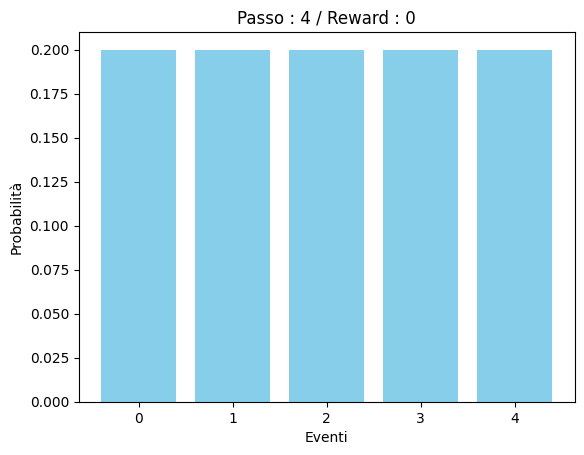

In [4]:
import matplotlib.pyplot as plt

for z in range (len(t)):
    # Creazione del grafico a barre
    plt.bar([i for i in range (0, n)], t[z], color='skyblue')
    # Aggiunta di titolo e etichette agli assi
    plt.title(f"Passo : {z} / Reward : {r}")
    plt.xlabel("Eventi")
    plt.ylabel("Probabilità")
    #plt.show() #togliere il commento per visualizzare l'evoluzione della funzione di probabilità

In [5]:
import keras

Proviamo ad abbinare il tutto alla nostra rete neurale.

In [6]:
class CustomModel(keras.Model):
    def __init__(self, input_size, number_of_hidden, output_size, hidden_size, activ = "relu", out_activ = "softmax"):
        super().__init__()
        self.input1 = keras.Input(shape=(input_size,)) # gli input sono 4
        self.hidden = []
        for i in range (number_of_hidden):
            self.hidden.append(keras.layers.Dense(hidden_size[i], activation = activ))
        self.output1 = keras.layers.Dense(output_size, activation = out_activ)

    def call(self, inputs):
        x = inputs
        for h in self.hidden:
            x = h(x)
        return self.output1(x) 

In [7]:
batch_size = 10 # equivale alla history size
input_size = 9
output_size = 3
reward = 1
x = np.array([[random.uniform(0, 1) for i in range(input_size)] for j in range (batch_size)])
history = [random.randrange(0, output_size) for i in range (batch_size)]
y = target_linear_scaling_distribution(reward, history, output_size)

In [8]:
m = CustomModel(input_size, 5, output_size, [18, 27, 18, 9, 6])
m.compile(optimizer=keras.optimizers.Adam(), loss= keras.losses.CategoricalCrossentropy() , metrics=[keras.metrics.CategoricalAccuracy()])

In [10]:
m.fit(x, y, batch_size, epochs= 100, verbose=0)

In [11]:
test = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])
y_test = m(test)
y_test[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.24729094, 0.45437717, 0.2983318 ], dtype=float32)>

Siamo molto soddisfatti. Possiamo dire che funziona. (sarà chiaramente da studiare ancora parecchio ma siamo su una buona strada). Bisogna assolutamente lavorare sul modello per capire come migliorare l'apprendimento del modello ma è ugualmente interessante. Vediamo che i "macro-comportamenti" li impara ed è un buon punto di partenza. Già aumentando la complessità del modello vediamo il miglioramento incredibile in termini di loss.

Implementiamo anche un'altro tipo di target_probability_distribution basato sempre in maniera lineare sull'azione che ha portato il reward ed il reward. Questa volta però non andiamo a creare uniformità sul resto della distribuzione ma andiamo a "riscalare" la distribuzione che abbiamo in input. Resta che le azioni sono indicizzate dunque la "royal action" sotto definità sarà in realtà l'indice dell'azione che ha portato al reward. In questo caso non andiamo a creare una "serie" di distribuzioni ma solo una singola distribuzione. I reward sono sempre numeri compresi tra -1 ed 1.

In [14]:
def target_linear_rescaled_distribution(reward, royal_action, starting_distribution):

    assert reward >= -1 and reward <= 1, 'reward must be between -1 and 1'

    starting_distribution = np.array(starting_distribution)
    coefficient = np.zeros(len(starting_distribution))
    new_royal_probability = min(1, starting_distribution[royal_action]*(1 + reward))
    coefficient[royal_action] = new_royal_probability # this is not the real coefficient we use it to be quicker

    if new_royal_probability == 1:
        return coefficient #just a trick to be quicker in case we hit a 1
    
    rest = starting_distribution[royal_action]*reward
    sum_others = 1 - starting_distribution[royal_action]
    ratio = rest/sum_others

    coefficient = np.ones(len(starting_distribution))*(1 - ratio)
    coefficient[royal_action] = (1 + reward)
    
    return starting_distribution*coefficient.T

In [18]:
reward = 1
r_a = 1
starting_p = [0.05 , 0.45, 0.5]
t = target_linear_rescaled_distribution(reward, r_a, starting_p)
t

array([0.00909091, 0.9       , 0.09090909])